<h1 style="text-align:center;">Лабораторная работа №4</h2>

<h2 style="text-align:center;">Решение нелинейного дифференциального уравнения с краевым условием</h2>

<h3 style="text-align:center;">Тулупов Николай Дмитриевич</h3>
<h3 style="text-align:center;">Б01-204</h3>

### **Введение**

Цель: решить нелинейное краевое ДУ 2 порядка методом стрельбы И методом квазилинеаризации Ньютона (проверить сходимость решения по расчетной сетке).

<img src="task.png" alt="drawing" width="500"/>

Здесь $p$ - параметр, управляющий степенью нелинейности.

In [32]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.integrate import solve_bvp

### **Встроенный метод**

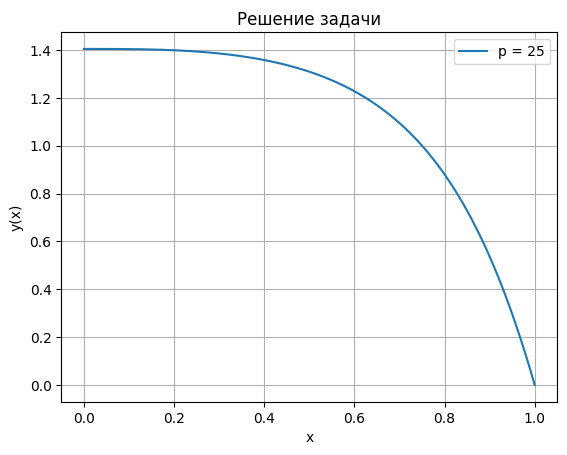

In [72]:
# Значение параметра p
p = 25  # можно менять: 1, 4, 7, 25, 50, 100

# Правая часть системы (y'' = -p x cos(y))
def ode_system(x, y):
    return np.vstack((y[1], -p * x * np.cos(y[0])))

# Граничные условия: y'(0)=0, y(1)=0
def boundary_conditions(ya, yb):
    return np.array([ya[1], yb[0]])

# Начальная сетка
x = np.linspace(0, 1, 100)
# Начальное приближение: y ≈ 1 - x, y' ≈ -1
y_init = np.vstack((1 - x, -np.ones_like(x)))

# Решение
solution = solve_bvp(ode_system, boundary_conditions, x, y_init)
y_prev_ = solution.sol(x)[0]
# Проверка и вывод
if solution.success:
    plt.plot(solution.x, solution.y[0], label=f'p = {p}')
    plt.xlabel('x')
    plt.ylabel('y(x)')
    plt.title('Решение задачи')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Решение не найдено:", solution.message)


### **Метод стрельбы**

Суть метода — заменить краевую задачу на начальную и подбирать начальное значение так, чтобы удовлетворялись условия на другом конце отрезка.
Уравнение нелинейное, но нежесткое почти при всех p, поэтому вполне адекватным будет использование явного метода РК4 из лабы 1.

In [52]:
def f(t, Y, p):
    y1, y2 = Y
    dy1 = y2
    dy2 = -p * t * np.cos(y1)
    return [dy1, dy2]

In [53]:
def runge_kutt_explicit(f, t, Y, h, order):
    l = len(Y)
    if order == 1:
        k1 = f(t, Y)
        return [ (Y[i] + h * k1[i])  for i in range(l)]
    
    elif order == 2:
        k1 = f(t, Y)
        Y_pred = [Y[i] + h * k1[i] for i in range(l)]  # прогноз
        k2 = f(t + h, Y_pred)
        return [Y[i] + h * (k1[i] + k2[i]) / 2 for i in range(l)]
    
    elif order == 3:
        k1 = f(t, Y)
        Y_pred_12 = [Y[i] + h * k1[i] / 2 for i in range(l)]
        k2 = f(t + h/2, Y_pred_12)
        Y_pred_23 =  [Y[i] - h * k1[i] + 2 * h * k2[i] for i in range(l)]
        k3 = f(t + h, Y_pred_23)
        return [Y[i] + h * (k1[i] + 4*k2[i] + k3[i]) / 6 for i in range(l)]
    
    elif order == 4:
        k1 = f(t, Y)
        Y_pred_12 = [Y[i] + h * k1[i] / 2 for i in range(l)]
        k2 = f(t + h / 2, Y_pred_12)
        Y_pred_23 = [Y[i] + h * k2[i] / 2 for i in range(l)]
        k3 = f(t + h / 2, Y_pred_23)
        Y_pred_34 = [Y[i] + h * k3[i] for i in range(l)]
        k4 = f(t + h, Y_pred_34)
        return [Y[i] + h * (k1[i] + 2*k2[i] + 2*k3[i] + k4[i]) / 6 for i in range(l)]
    
    else:
        print("ERROR! Порядок должен быть от 1 до 4")
        return 

In [54]:
def integrate_runge_kutt_explicit(f, Y0, t_start, t_stop, h, order):
    t = t_start
    Y = Y0[:]
    S = [[t] + Y] 

    while t < t_stop:
        Y = runge_kutt_explicit(f, t, Y, h, order)
        t += h
        S.append([t] + Y)

    return S #траектория

Функция integrate_runge_kutt_explicit(f, Y0, t_start, t_stop, h, order) не нужна - она возвращает целую траекторию, а нам нужно лишь конечное значение.

In [ ]:
def solve_shooting(a0, p, h=0.01, order=4):
    f_wrapped = lambda t, Y: f(t, Y, p)
    Y0 = [a0, 0]
    S = integrate_runge_kutt_explicit(f_wrapped, Y0, 0, 1, h, order)
    return S[-1][1]  # это y(1) — значение в конце, сравниваем с нулём


Подбор $а0$ произведем через метод секущих:
$$a_{new} = a_2 - (a_2-a_1) * y_2 / (y_2-y_1)  $$
То есть проводим прямую через точки $(a1, y1)$ и $(a2, y2)$ и ищем ее пересечение с осью $y=0$.   
Если новое $y(1)$ достаточно близко к нулю — решение найдено. Если нет - продвигаемся по ходу вычислений — берём последние две точки и повторяем.

In [56]:
def shooting_method_secant(p, a1, a2, tol=1e-6, max_iter=1000):
    y1 = solve_shooting(a1, p)
    y2 = solve_shooting(a2, p)
    
    for _ in range(max_iter):
        if abs(y2 - y1) < 1e-12: break  # защита от деления на 0
        a_new = a2 - y2 * (a2 - a1) / (y2 - y1)
        y_new = solve_shooting(a_new, p)
        if abs(y_new) < tol:
            return a_new
        a1, y1 = a2, y2
        a2, y2 = a_new, y_new
    print("Метод секущих не сошелся за max_iter!")
    return a2  # если не сошлось, возвращаем последнее значение


In [57]:
p = 100
a_values = np.linspace(0, 3, 100)
y1_values = [solve_shooting(a, p) for a in a_values]

a0_found = shooting_method_secant(p, 0.1, 1.5)
print("Подобранное y(0):", a0_found)

Подобранное y(0): 1.5641073095346256


In [58]:
p = 100
a_values = np.linspace(0, 3, 100)
y1_values = [solve_shooting(a, p) for a in a_values]

a0_found = shooting_method_secant(p, a_values[0], a_values[-1])
print("Подобранное y(0):", a0_found)

Подобранное y(0): -4.438175413023454


Как видим, если взять достаточно широкий диапазон, на котором при больших p функция имеет несколько корней или даже осциллирует, метод секущих может уйти к "не тому корню" или вообще в сторону ложного корня.   
В случае небольшого диапазона - там функция почти линейна, только один корень, и метод секущих его уверенно находит.   

В связи с этим перепишем фукнцию стрельбы методом бисекции - постоянного деления на 2. Этот метод будет искать корень медленнее и требует, чтобы на концах интервала были разные знаки. Зато его использование гарантирует, что найденный корень будет лежать в интервале.

In [59]:
def shooting_method_bisection(p, a1, a2, tol=1e-6, max_iter=1000):
    y1 = solve_shooting(a1, p)
    y2 = solve_shooting(a2, p)

    if y1 * y2 > 0:
        print("На концах отрезка одинаковые знаки — метод бисекции не применим!")
        return None

    for _ in range(max_iter):
        a_mid = (a1 + a2) / 2
        y_mid = solve_shooting(a_mid, p)

        if abs(y_mid) < tol:
            return a_mid

        if y1 * y_mid < 0:
            a2, y2 = a_mid, y_mid
        else:
            a1, y1 = a_mid, y_mid

        if abs(a2 - a1) < tol:
            return (a1 + a2) / 2

    print("Бисекция не сошлась за max_iter")
    return (a1 + a2) / 2


In [60]:
p = 100
a_values = np.linspace(0, 3, 100)
y1_values = [solve_shooting(a, p) for a in a_values]

a0_found = shooting_method_bisection(p, 0.1, 1.5)
print("Подобранное y(0):", a0_found)

На концах отрезка одинаковые знаки — метод бисекции не применим!
Подобранное y(0): None


In [61]:
p = 100
a_values = np.linspace(0, 3, 100)
y1_values = [solve_shooting(a, p) for a in a_values]

a0_found = shooting_method_bisection(p, a_values[0], a_values[-1])
print("Подобранное y(0):", a0_found)

Подобранное y(0): 1.5641072988510132


Подобранное y(0): 1.5641072518897783


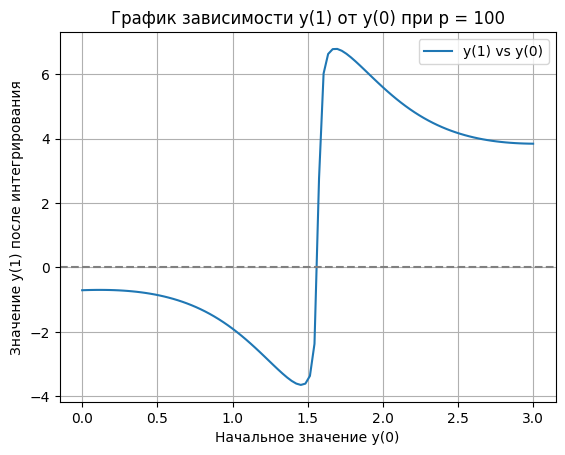

In [62]:
p = 100
a_values = np.linspace(0, 3, 100)
y1_values = [solve_shooting(a, p) for a in a_values]

a0_found = shooting_method_bisection(p, a_values[1], a_values[-1])
print("Подобранное y(0):", a0_found)

plt.plot(a_values, y1_values, label='y(1) vs y(0)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Начальное значение y(0)')
plt.ylabel('Значение y(1) после интегрирования')
plt.title(f'График зависимости y(1) от y(0) при p = {p}')
plt.grid(True)
plt.legend()
plt.show()

Подобранное y(0): -4.438175467812256


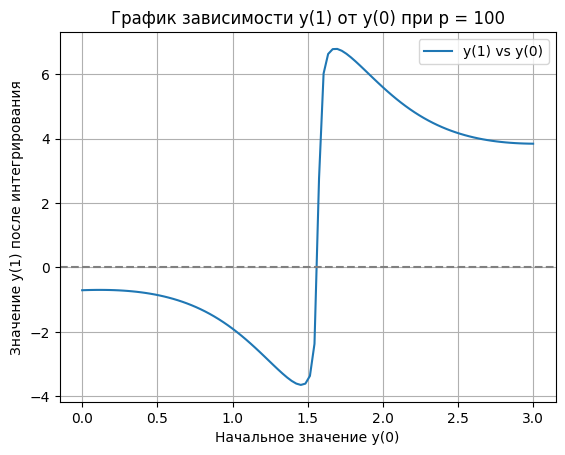

In [63]:
p = 100
a_values = np.linspace(0, 3, 100)
y1_values = [solve_shooting(a, p) for a in a_values]

a0_found = shooting_method_secant(p, a_values[1], a_values[-1])
print("Подобранное y(0):", a0_found)

plt.plot(a_values, y1_values, label='y(1) vs y(0)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Начальное значение y(0)')
plt.ylabel('Значение y(1) после интегрирования')
plt.title(f'График зависимости y(1) от y(0) при p = {p}')
plt.grid(True)
plt.legend()
plt.show()

In [64]:
def drawing():
    p_vals = [1, 4, 7, 25, 50, 100]
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 2 строки, 3 столбца
    axs = axs.flatten()  # чтобы обращаться как axs[0], axs[1], ...

    for i in range(len(p_vals)):
        p = p_vals[i]
        a_values = np.linspace(0, 3, 100)
        y1_values = [solve_shooting(a, p) for a in a_values]

        a0_found = shooting_method_bisection(p, a_values[1], a_values[-1])

        axs[i].plot(a_values, y1_values)
        axs[i].axhline(0, color='gray', linestyle='--')
        axs[i].set_title(f"p = {p}, найденное y(0) ≈ {a0_found:.4f}")
        axs[i].set_xlabel('y(0)')
        axs[i].set_ylabel('y(1)') 
        axs[i].grid(True)


    fig.suptitle(f"а", fontsize=16)
    plt.tight_layout()
    plt.show()

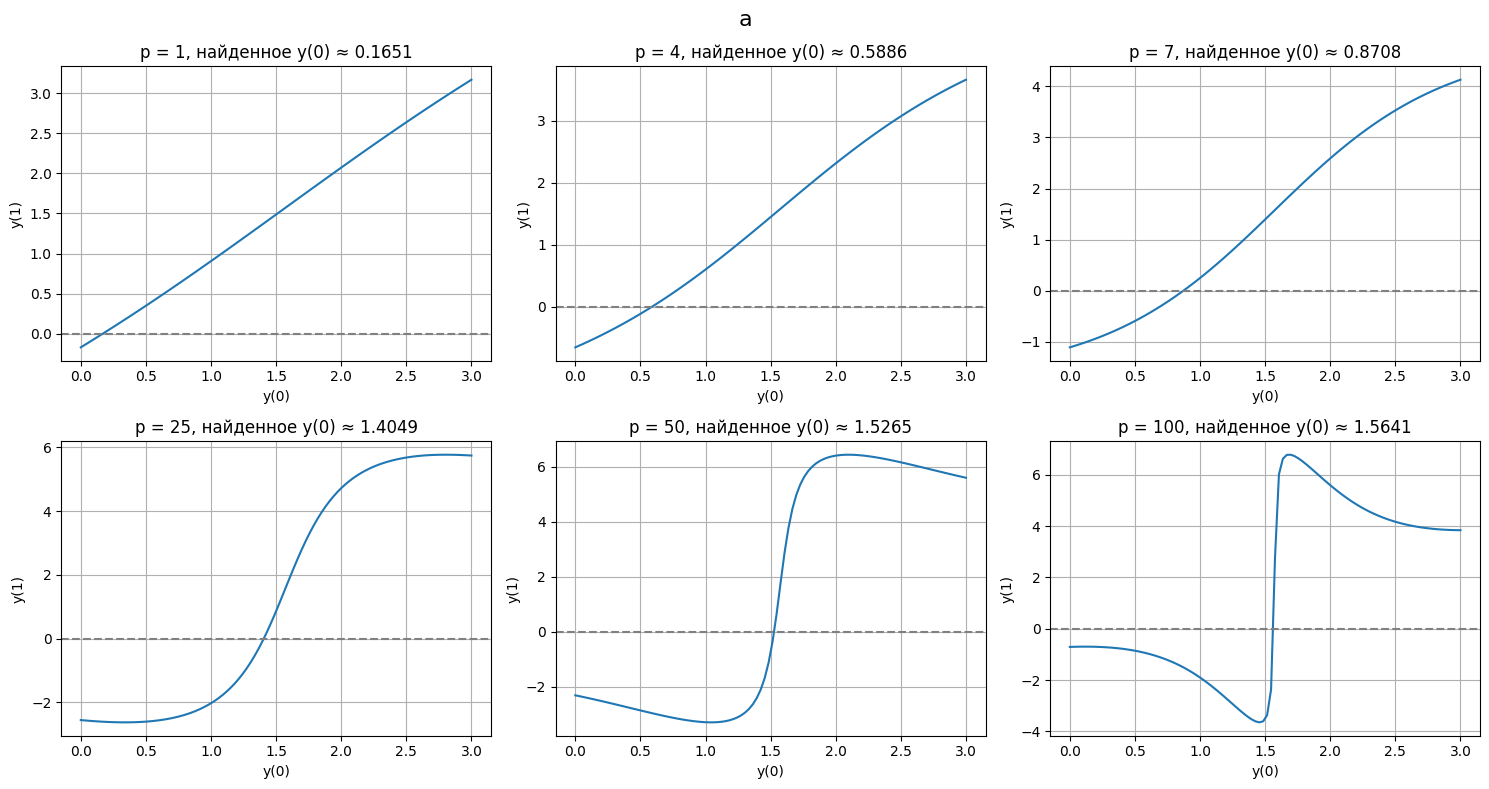

In [65]:
drawing()

 Выводы из графиков:    
- Когда $p$ маленькое (1, 4, 7):    
  Слагаемое $𝑦pxcosy$ ещё слабо влияет и поведение $y(x)$ почти линейное. Зависимость $y(1)$ от $y(0)$ — почти прямая линия.   
  Это говорит о почти линейном отклике: маленькое изменение в начале → маленькое изменение в конце

- Когда $p$ большое (25, 50, 100):    
 $𝑦pxcosy$ становится сильное нелинейным, при больших $y$ $cos(y)$ осциллирует. Уравнение начинает резонировать, и траектории становятся непредсказуемыми 
 Это признак жёсткой нелинейной системы. Поведение становится нестабильным и даже хаотичным на графике зависимости y(1) от y(0).


Нарисуем само решение, которое выдает данный метод.

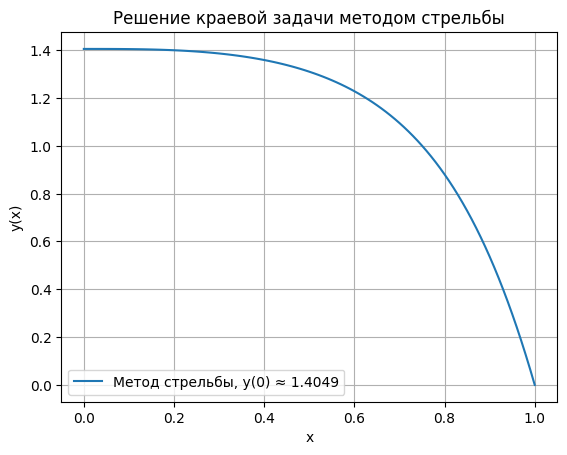

In [69]:
def solve_trajectory(a0, p, h=0.01, order=4):
    f_wrapped = lambda t, Y: f(t, Y, p)
    Y0 = [a0, 0]
    S = integrate_runge_kutt_explicit(f_wrapped, Y0, 0, 1, h, order)
    return np.array([row[1] for row in S]), np.array([row[0] for row in S])


a0 = shooting_method_bisection(p=25, a1=1.05, a2=3.0)
y_traj, x_vals = solve_trajectory(a0, p=25)

plt.plot(x_vals, y_traj, label=f"Метод стрельбы, y(0) ≈ {a0:.4f}")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("Решение краевой задачи методом стрельбы")
plt.grid(True)
plt.legend()
plt.show()


### **Метод квазилинеаризации Ньютона**

Это способ решения нелинейных краевых задач, в котором:
- нелинейное уравнение приводится к последовательности линейных
- на каждом шаге решаем линейную краевую задачу, приближаясь к настоящему решению

Это способ решения нелинейных краевых задач, вида $$y'' + f(x, y) = 0,\quad y(a) = \alpha,\quad y(b) = \beta$$,в котором:
- нелинейное уравнение приводится к последовательности линейных
- на каждом шаге решаем линейную краевую задачу, приближаясь к настоящему решению

Суть метода заключается в последовательной замене исходного уравнения линейными по аналогии с методом Ньютона:
  1. Задаётся начальное приближение $y^{(0)}(x)$ (например, линейная интерполяция).
  2. На каждом шаге строится линейное уравнение:
  $$
  y_{k+1}'' + f_y(x, y_k)\cdot y_{k+1} = -f(x, y_k) + f_y(x, y_k)\cdot y_k
  $$
  где $f_y$ — производная $f$ по $y$.      

  3.  Полученное уравнение аппроксимируется разностной схемой и решается как СЛАУ.             
  4. Итерации продолжаются до тех пор, пока не будет достигнута сходимость:
  $$
  \max_i \left| y_i^{(k+1)} - y_i^{(k)} \right| < \varepsilon
  $$


В рамках данной задачи используется уравнение:

$$
y'' + p x \cos y = 0,\quad y'(0) = 0,\quad y(1) = 0
$$

где:
$$
f(x, y) = p x \cos y,\quad f_y(x, y) = -p x \sin y
$$

Таким образом, на каждом шаге решается линейная краевая задача, которая приближает решение исходной нелинейной. 
Решение СЛАУ сделаем своим методом Гаусса.


In [ ]:
def swap_rows(A, row1, row2): #функция для смены строк в матрице
    A[[row1, row2]] = A[[row2, row1]]

def swap_columns(A, col1, col2): #функция для смены столбцов в матрице
    if A.ndim == 2:
        A[:, [col1, col2]] = A[:, [col2, col1]]
    elif A.ndim == 1:
        A[[col1, col2]] = A[[col2, col1]]

#функция для поиска главного элемента матрицы A[iter, iter]
def find_max_el(A, iter):
    subA = A[iter:, iter:]
    main_element = subA[0, 0]
    i_main, j_main = iter, iter

    for i in range(subA.shape[0]):
        for j in range(subA.shape[1]):
            if abs(subA[i, j]) > abs(main_element):
                main_element = subA[i, j]
                i_main, j_main = iter + i, iter + j

    return main_element, i_main, j_main

def gauss(A, f):
    #print("Решение СЛАУ методом Гаусса с выбором макс элемента")
    size = len(A)
    if A.shape[0] != A.shape[1]:
        print("Матрица не квадратная, решение невозможно!")
        return 
    x = np.arange(size) #массив с порядком корней (порядок будет меняться при перестановке столбцов)

    #прямой ход алгоритма - приводим матрицу A к верхнетреугольному виду
    for iter in range(len(A)):
        ''' Добавим в алгоритм проверку - если на какой-то итерации алгоритма возникла нулевая строка - ответ будет выражаться 
        через одну из переменных (её берем за константу, все остальные переменные будут выражены через нее)'''
        if (len(A) != sum(int(np.any(el)) for el in A)):
            '''Количество переменных превышает количество уравнений, решение не однозначн'''
            print("ERROR! Матрица не квадратная, решение невозможно!")
            return 
        
        main_el, i_main, j_main = find_max_el(A, iter) #максимальный элемент текущей матрицы и его местонахождение
        
        if (i_main != iter): #если элемент еще не в нулевой строке
            swap_rows(A, iter, i_main) #меняем в текущей матрице нулевую строку и строку, содержащую главный элемент            
            swap_rows(f, iter, i_main) #то же самое - в столбце решений       
            
        if (j_main != iter): #если элемент еще не в нулевом столбце
            swap_columns(A, iter, j_main) #меняем в текущей матрице нулевой столбец и столбец, содержащий главный элемент
            swap_columns(x, iter, j_main) #то же самое - в строке порядка переменных
        
        if main_el != 0:
            A[iter:, iter:][0] /= main_el #делим нулевую строку текущей матрицы на главный элемент
            f[iter] /= main_el #делим нулевую строку текущего столбца решений на главный элемент
        else:
            print("ERROR! main_el = 0")
            return
    
        for i in range(size - iter - 1):   
            f[i+iter+1] -= (f[iter] * A[iter:, iter:][i+1][0])
            #вычитаем из каждого элемента нулевой в текущем столбце решений, умноженный на нулевой элемент нужной строки - получаем в начале каждой строки единицу
            A[iter:, iter:][i+1] -=  (A[iter:, iter:][0] * A[iter:, iter:][i+1][0])
            #вычитаем из каждой строки нулевую, умноженную на нулевой элемент нужной строки - получаем в начале каждой строки единицу
        
    f[-1] /= A[-1][-1]
    A[size-1][size-1] = 1


    
    #обратный ход алгоритма
    U  = np.zeros((size, 1)) #столбец решений
    for i in range(size-1, -1, -1):
        U[i] = f[i]
        for j in range(i + 1, size):
            U[i] -= U[j] * A[i][j]

    #перестановка переменных в изначальном порядке
    ans = np.zeros((size, 1))
    for i in range(size):
        ans[int(x[i])] = U[i]
    
    return ans

In [ ]:
def newton_quasilinear(p, N, eps=1e-6, max_iter=300):
    h = 1 / N
    x = np.linspace(0, 1, N + 1)
    # y_prev = np.zeros(N + 1)
    # y_prev = np.linspace(1.4049, 0, N + 1)  # вместо нулей
    # y_prev = np.cos(np.pi * x / 2) - 1  # удовлетворяет y(1)=0 и y′(0)=0

    y_prev = 1.40487619e+00  * (np.cos(np.pi * x / 2) )

    for iter in range(max_iter):
        # Коэффициенты СЛАУ
        A = np.zeros((N + 1, N + 1))
        f = np.zeros((N + 1, 1))

        # Граничное условие y'(0) = 0 → симметрия: y_1 = y_{-1}
        A[0][0] = -1 / h
        A[0][1] = 1 / h
        f[0][0] = 0

        # Внутренние узлы
        for i in range(1, N):
            xi = x[i]
            si = -p * xi * np.sin(y_prev[i])
            fi = -p * xi * np.cos(y_prev[i]) + p * xi * np.sin(y_prev[i]) * y_prev[i]

            A[i][i - 1] = 1 / h**2
            A[i][i]     = -2 / h**2 - si
            A[i][i + 1] = 1 / h**2
            f[i][0]     = fi

        # Граничное условие y(1) = 0
        A[N][N] = 1
        f[N][0] = 0

        # Решаем СЛАУ методом Гаусса
        #y_new = gauss(np.copy(A), np.copy(f))
        y_new = np.linalg.solve(A, f).flatten()
        if y_new is None:
            print("Метод Гаусса не сработал")
            return None

        # Проверка сходимости
        if np.max(np.abs(y_new.flatten() - y_prev)) < eps:
            print(f"Сошлось за {iter + 1} итераций")
            return x, y_new.flatten()

        y_prev = y_new.flatten()

    print("Не сошлось за максимальное число итераций")
    return x, y_prev


Не сошлось за максимальное число итераций


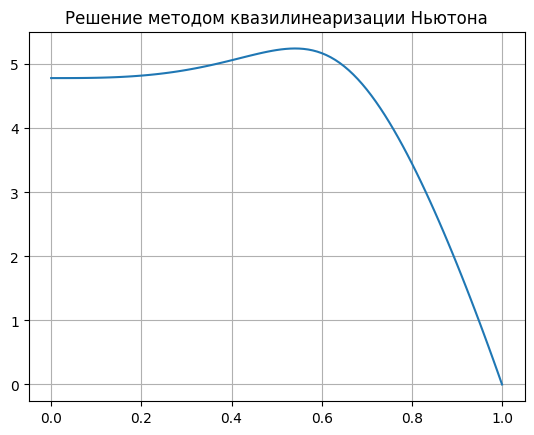

In [ ]:
x, y = newton_quasilinear(p=25, N=100)
plt.plot(x, y)
plt.title("Решение методом квазилинеаризации Ньютона")
plt.grid(True)
plt.show()

Как видим, форма кривой похожа на нужную, но начальное приближение требуется подкорректировать. В качестве начального приближения возьмем решение из метода стрельбы.   
Саму функцию метода тоже немного изменим и добавим 2 пост-итерации для улучшения точности.

In [71]:
def newton_quasilinear(p, x, y_prev, eps=1e-6, max_iter=300):
    h = x[1] - x[0]
    N = len(x) - 1

    for _ in range(max_iter):
        A = np.zeros((N + 1, N + 1))
        f = np.zeros((N + 1, 1))

        A[0][0] = -1 / h
        A[0][1] = 1 / h
        f[0][0] = 0

        for i in range(1, N):
            xi = x[i]
            si = -p * xi * np.sin(y_prev[i])
            fi = -p * xi * np.cos(y_prev[i]) + si * y_prev[i]

            A[i][i - 1] = 1 / h**2
            A[i][i]     = -2 / h**2 - si
            A[i][i + 1] = 1 / h**2
            f[i][0]     = fi

        A[N][N] = 1
        f[N][0] = 0
        try:
            y_new = gauss(A, f)
            # y_new = np.linalg.solve(A, f).flatten()
        except Exception as e:
            print("Ошибка при решении СЛАУ:", e)
            return y_prev

        post_iters = 2
        if np.max(np.abs(y_new - y_prev)) < eps:
                for _ in range(post_iters):
                    y_prev = y_new.copy()
                    # построить новую матрицу A и вектор f, как в основном цикле
                    # повторить одну итерацию (можно вынести в функцию)
            
                return y_new
        
        
        y_prev = y_new

    print("Метод Ньютона не сошёлся")
    return y_prev

C:\Users\pc\AppData\Local\Temp\ipykernel_19912\1594819665.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A[i][i]     = -2 / h**2 - si
C:\Users\pc\AppData\Local\Temp\ipykernel_19912\1594819665.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[i][0]     = fi


Метод Ньютона не сошёлся


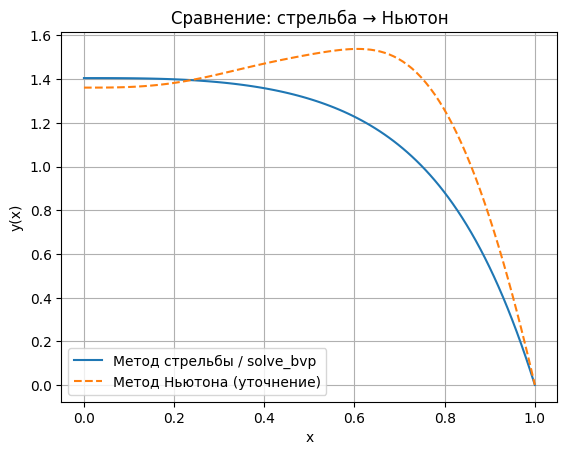

In [ ]:
y_n = newton_quasilinear(p, x, y_prev_)

plt.plot(x, y_prev_, label="Метод стрельбы / solve_bvp")
plt.plot(x, y_n, '--', label="Метод Ньютона (уточнение)")
plt.title("Сравнение: стрельба → Ньютон")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.grid(True)
plt.legend()
plt.show()


### **Выводы**

**Сравнение метода Ньютона и метода стрельбы**

| Критерий                          | Метод Ньютона                                     | Метод стрельбы                                 |
|----------------------------------|---------------------------------------------------|------------------------------------------------|
| Принцип                          | Решает систему уравнений на всей сетке           | Интегрирует задачу Коши с подбором начального значения |
| Вычислительная сложность         | Высокая: требует многократного решения СЛАУ       | Низкая: одна интеграция + простая бисекция     |
| Требование к начальному приближению | Критично: при плохом `y₀` возможен срыв сходимости | Менее критично: устойчив к выбору начальных значений |
| Ошибки                           | Распределяются по всей сетке, могут накапливаться | Локальны вдоль траектории, легко контролируются |
| Метод дискретизации              | Конечные разности (менее точные)                 | Рунге-Кутта (высокая точность)                 |
| Сходимость                       | Не гарантирована при сильной нелинейности         | Гарантирована при корректной реализации         |
| Поведение при больших p          | Может уйти на ложную ветвь                       | Надёжно выводит на правильное решение           |
